This is needed to work with data stored on Drive with Colab. Uses external libraries to authenticate and access the files on Drive of the current account.

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

# Where the files will be stored
cd /content/drive/TFM

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


Definition of the required libraries. Most of them are standard for any DS project.

We use our *preprocessing* library to handle the input of the images and extraction of the patches.

We use the *losses* library to handle losses for the segmentation models.

We use the *models* library to store the models to test.

In [4]:
#Imports
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import random

from preprocessing import load_images, get_patch, sample_image, accuracy

from keras import optimizers

from losses import bce_dice_loss, dice_loss, weighted_bce_dice_loss, weighted_dice_loss, dice_coeff

from model import Deeplabv3, unet_256

#Global Variables
train_dir = 'data/train_resized/'
img_size = (512,512)
num_images = 6226

Using TensorFlow backend.


First step is to load the images. We have reduced the size of the images to 512x512 due to computational costs. The images are loaded and stored as matrices of size 512x512x3.

In [5]:
images = load_images(num_images, 'data/train_resized/')

The following step is to create a train set for the model. We will extract smaller patches of a given size from the images and apply rotations as a way to do data augmentation and find roads in different angles.

The *build_set* function takes as input the set of images, how many patches we want to sample from each one, the size of the patches and the rotations to be applied.

The output is of a set of tuples (patch_size, patch_size, 3) in which one image is the satelite image and the other the mask corresponding to the roads in the image. We will refer to the satelite images as the X set and the mask will be called as the Y set.

In [6]:
def build_set(images, num_patches, patch_size, rotations):
  Y_train = []
  X_train = []
  
  i=0
  for image in images:
    print(i)
    i+=1
    if i not in [246,313,779]:
      mask = np.array(image[0].convert("L"))
      if np.sum(mask[patch_size:-patch_size,patch_size:-patch_size])!=0: #Check whether there is any possible patch with a road
        Y, X = sample_image(image[0], image[1], num_patches = num_patches, patch_size = patch_size, rotations = rotations)
        Y_train.append(Y)
        X_train.append(X)

  Y_train = np.array(Y_train)
  Y_train = Y_train.reshape(Y_train.shape[0]*Y_train.shape[1],Y_train.shape[2],Y_train.shape[3])
  X_train = np.array(X_train)
  X_train = X_train.reshape(X_train.shape[0]*X_train.shape[1],X_train.shape[2],X_train.shape[3],X_train.shape[4])
  
  return X_train, Y_train

Once we have the training set prepared we have to build the models. The following function accepts as a parameter either the unet models or the DeepLabv3 model and models it with the given parameters.

The return of the following function is the compiled model ready to be trained with out input data.

In [0]:
def build_model(X_train, Y_train, model_name = 'unet_256', epochs=100, shuffle=True, verbose=1, batch_size=64, summary = True):
  model = False
  if model_name == 'unet_256':
    model = unet_256(input_shape=(64,64,3),num_classes=1)
  if model_name == 'Deeplabv3':
    model = Deeplabv3(weights = None, input_shape=(64,64,3), classes=1)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizers.SGD(lr=0.0001),
                  metrics=['accuracy'])
  if summary: model.summary()
  model.fit(X_train, Y_train.reshape(Y_train.shape[0],64,64,1), epochs=epochs, shuffle=shuffle, verbose=verbose, batch_size=batch_size)
  return model


We create a simple function that we will use to visualize the results.

In [7]:
def show_prediction(X_train, Y_train, Y_pred, i):
  plt.figure()
  plt.imshow(X_train[i])
  plt.figure()
  plt.imshow(Y_train[i])
  plt.figure()
  plt.imshow(Y_pred[i])
  
#show_prediction(X_train, Y_train, Y, 0)

The predict functions simply process the input images to be fed as an input to the predict function of the trained model.

In [8]:
def predict_mask(X, model, batch_size, th=0.5):
  Y = model.predict(X, batch_size=batch_size)
  print(Y[1,1,1,:])
  Y = Y.reshape(Y_train.shape[0],64,64)
  Y = Y > th
  return Y

def predict_mask_greyscale(X, model, batch_size):
  Y = model.predict(X, batch_size=batch_size)
  Y = Y.reshape(700,64,64)
  return Y

#Y = predict_mask(X_train, model, batch_size=100)

Now we are ready to perform the full test. We create the train set, select and build the model and train it with the train set. We perform both preditions with the train set and a test set to evaluate performance.

In [0]:
def full_test(img_num, num_patches, size_patches, summary = False, batch_size = 10000, seeds = [42, 64], test_image = 0):
  print('Creating train set...')
  X_train, Y_train = build_set(images, num_patches = 10, patch_size = 64, rotations = [0,90])

  print('Generating model...')
  model = build_model(X_train, Y_train, model_name = 'unet_256', summary=True)

  print('Prediction with train set:')
  Y = predict_mask(X_train, model, batch_size=100)
  show_prediction(X_train, Y_train, Y, 1)

  ab=b

  print('Prediction with test set:')
  np.random.seed(37)
  X_test, Y_test = build_set(images, num_patches = 10, patch_size = 64, rotations = [0])
  Y = predict_mask(X_test, model, batch_size=10000)
  show_prediction(X_test, Y_test, Y, test_image)

Prediction with train set:
[0.13094313]


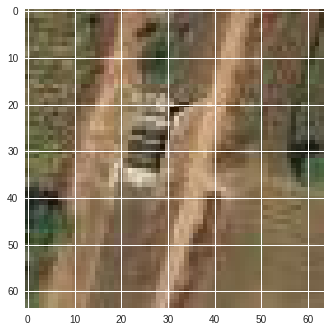

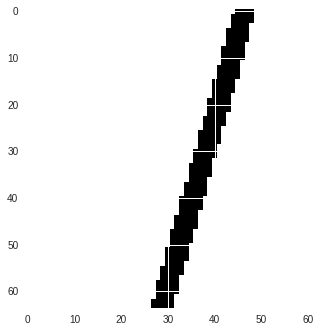

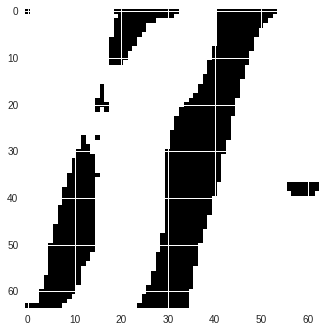

In [10]:
print('Prediction with train set:')
Y = predict_mask(X_test, model, batch_size=100)
show_prediction(X_test, Y_train, Y, 1)

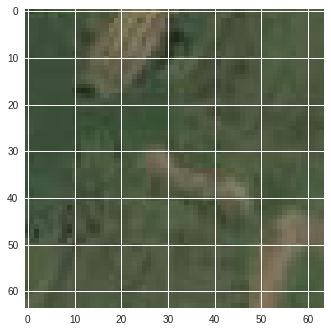

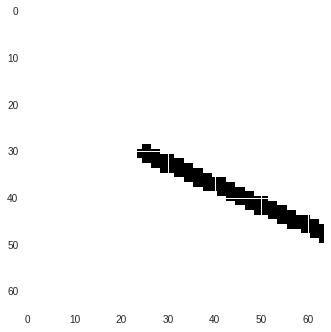

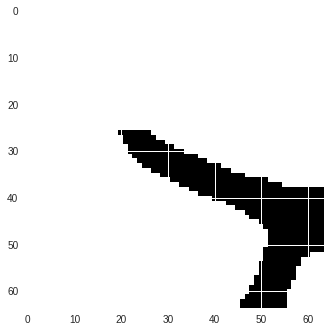

In [67]:
show_prediction(X_test, Y_test, Y, 2312)

Finally we can take a look at simple accuracy metrics.

In [61]:
acc = []
for i in range(1000):
  acc.append(accuracy(Y_test[i], Y[i]))
print(sum(acc)/len(acc))

0.8156219407588714


Prediction with train set:


0.93603515625

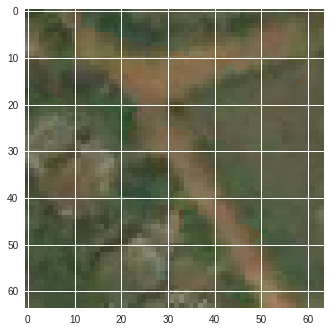

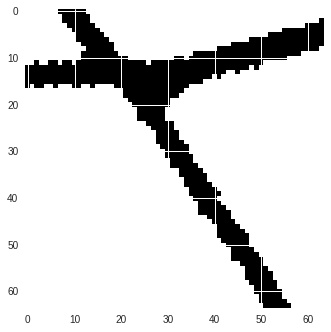

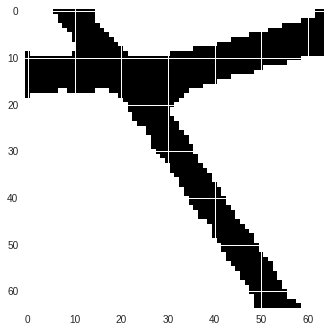

In [41]:
print('Prediction with train set:')
Y = predict_mask(X_train, model, batch_size=10000)
show_prediction(X_train, Y_train, Y, 20)

def accuracy(original, predicted):
    difference = np.absolute(original/255 - predicted)
    if np.sum(difference)>(difference.shape[0]*difference.shape[1]): return False
    accuracy = 1. - np.sum(difference)/(difference.shape[0]*difference.shape[1])
    return accuracy
  
  
accuracy(Y_train[20], Y[20])